# Optimisation: First example

This example shows you how to run a global optimisation with Pints.

First, we import pints:

In [1]:
import pints

Next, we need a model: any class that implements the [pints.ForwardModel interface](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#forward-model).

Usually, you'd write a class for this purpose (that wrapped around whatever simulation package you wanted to use to generate your time series data). But you could also use a pure-Python model.

In the example, we use a [logistic model](https://en.wikipedia.org/wiki/Logistic_function), provided by [Pints's toy model module](http://pints.readthedocs.io/en/latest/toy/index.html).

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

This model has two parameters: A growth rate (which determines the steepness of the curve) and a carrying capacity (which determines the number the curve converges to).
For the example, we simply pick some nice values:

In [3]:
real_parameters = [0.015, 500]

Finally, we create a list of times (in a real experiment, these would be the times at which the time series was sampled)

In [4]:
import numpy as np
times = np.linspace(0, 1000, 100)

We now have everything we need to run a simulation and generate some toy data:

In [5]:
values = model.simulate(real_parameters, times)

We can use Matplotlib (or any other plotting package) to have a look at the generated data:

In [6]:
import matplotlib.pyplot as plt

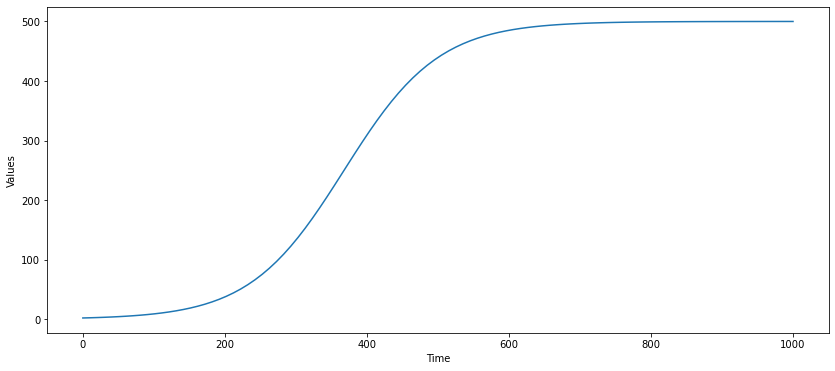

In [7]:
plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values)
plt.show()

We now set up an optimisation, to see if we can recover our original parameters from this data.

First, we define a problem (in this case a [single-valued time series fitting problem](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#pints.SingleOutputProblem)):

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

We then define an [error measure](http://pints.readthedocs.io/en/latest/error_measures.html) on this problem:

In [9]:
error = pints.SumOfSquaresError(problem)

A lot of real problems have physical constraints on the values the parameters can take, so in this example we add them in the form of [boundaries](http://pints.readthedocs.io/en/latest/boundaries.html):

In [10]:
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])

Finally, we define an initial position to start searching at

In [11]:
x0 = np.array([0.5, 500])

We now run an optimisation, using the [xNES](http://pints.readthedocs.io/en/latest/optimisers/xnes.html) method (although we could also have used a different global [optimiser](http://pints.readthedocs.io/en/latest/optimisers/index.html), like [CMA-ES](http://pints.readthedocs.io/en/latest/optimisers/cmaes.html) or [PSO](http://pints.readthedocs.io/en/latest/optimisers/pso.html)):

In [12]:
found_parameters, found_value = pints.optimise(
    error,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time m:s
0     6      4210287   4210287    0:00.0
1     12     4006344   4006344    0:00.0
2     18     4006344   4046089    0:00.0
3     24     3951076   3951076    0:00.0
20    126    258038.3  258038.3   0:00.0
40    246    64.85713  291.2191   0:00.0
60    366    0.231     0.379      0:00.0
80    486    0.000285  0.000456   0:00.1
100   606    5.75e-08  5.75e-08   0:00.1
120   726    2.94e-09  6.59e-09   0:00.1
140   846    2.26e-14  5.23e-12   0:00.1
160   966    1.72e-14  1.72e-14   0:00.1
180   1086   7.85e-18  4.05e-16   0:00.1
200   1206   9.78e-21  1.1e-19    0:00.1
220   1326   1.28e-22  3.24e-22   0:00.1
240   1446   0         1.86e-25   0:00.1
260   1566   0         0          0:00.2
280   1686   0         0          0:00.2
300   1806   0         0          0:00.2
320   1926   0         0          0:00.2
340   2040   0 

We can now look at the quality of the fit by running a simulation with the obtained parameters and plotting it on top of the noisy data:

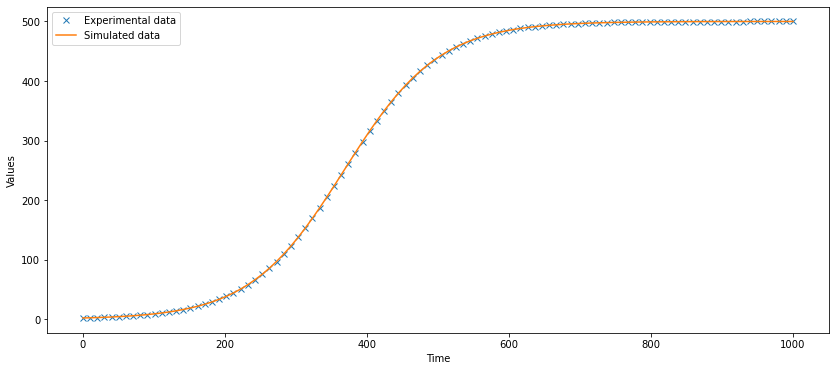

In [13]:
values2 = model.simulate(found_parameters, times)

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, 'x', label='Experimental data')
plt.plot(times, values2, label='Simulated data')
plt.legend()
plt.show()

Because this was a toy model, we can also compare the parameters with the known true parameters:

In [14]:
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Found solution:          True parameters:
 1.49999999999999994e-02     1.49999999999999994e-02
 5.00000000000000000e+02     5.00000000000000000e+02


## Fitting to noisy data

We now repeat this exercise with noisy data:

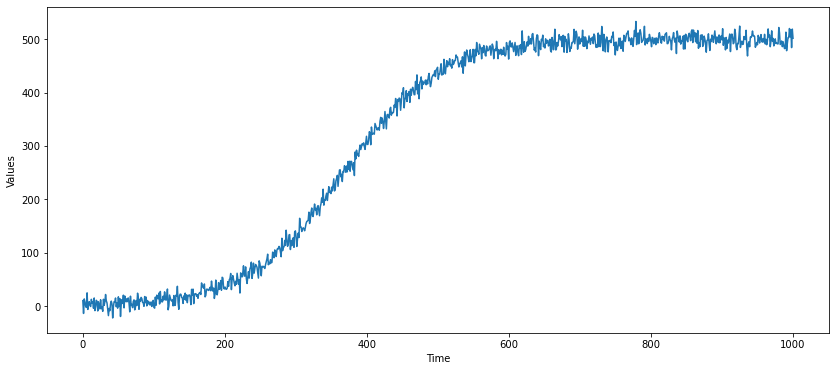

In [15]:
times = np.linspace(0, 1000, 1000)

values = model.simulate(real_parameters, times)
values += np.random.normal(size=values.shape) * 10

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values)
plt.show()

Again, we set up a problem, define an error measure, and run the optimisation:

In [16]:
problem = pints.SingleOutputProblem(model, times, values)
error = pints.SumOfSquaresError(problem)

found_parameters, found_value = pints.optimise(
    error,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time m:s
0     6      4.01e+07  4.01e+07   0:00.0
1     12     3.98e+07  3.98e+07   0:00.0
2     18     3.98e+07  4.09e+07   0:00.0
3     24     3.98e+07  4.01e+07   0:00.0
20    126    1.4e+07   2.82e+07   0:00.0
40    246    372835.1  5173646    0:00.0
60    366    372835.1  390311.3   0:00.0
80    486    99957.08  99957.08   0:00.1
100   606    99950.41  99950.41   0:00.1
120   726    99950.39  99950.39   0:00.1
140   846    99950.39  99950.39   0:00.1
160   966    99950.39  99950.39   0:00.1
180   1086   99950.39  99950.39   0:00.1
200   1206   99950.39  99950.39   0:00.1
220   1326   99950.39  99950.39   0:00.1
240   1446   99950.39  99950.39   0:00.2
260   1566   99950.39  99950.39   0:00.2
280   1686   99950.39  99950.39   0:00.2
300   1806   99950.39  99950.39   0:00.2
320   1926   99950.39  99950.39   0:00.2
340   2046   99

And we can inspect the result by plotting a simulation:

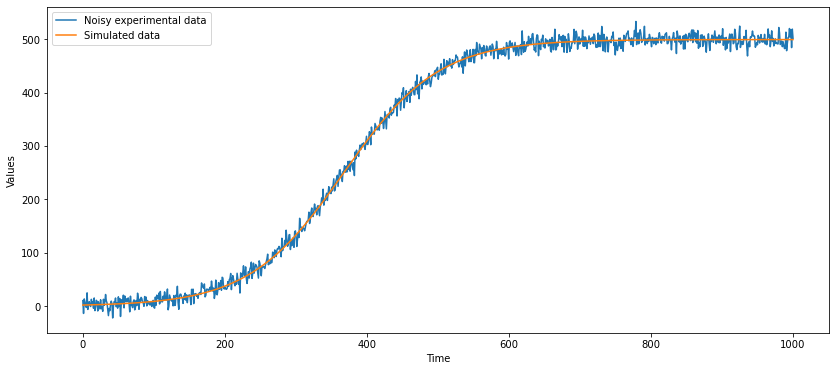

In [17]:
values2 = model.simulate(found_parameters, times)

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy experimental data')
plt.plot(times, values2, label='Simulated data')
plt.legend()
plt.show()

Looks like a great fit!

Because it's still a toy problem, we can look at the parameter values as well:

In [18]:
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Found solution:          True parameters:
 1.50152863475838672e-02     1.49999999999999994e-02
 4.99226328917909427e+02     5.00000000000000000e+02


So it looks like we were close, but not _exactly_ at the right parameters.

Why didn't we find _exactly_ the right solution in the noisy case?

To investigate this, we start by looking at the error measure, evaluated at the true solution and at the obtained solution:

In [19]:
print('Error at obtained solution: ')
print(error(found_parameters))

print('Error at true solution: ')
print(error(real_parameters))

Error at obtained solution: 
99950.39221952029
Error at true solution: 
100223.80925686713


Another way to compare them is to plot the error function on a line drawn between these points:

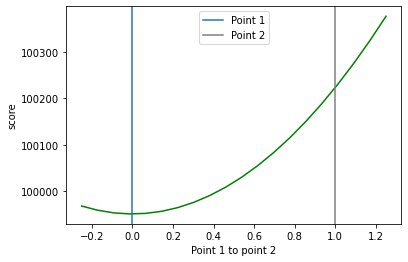

In [20]:
import pints.plot
fig, axes = pints.plot.function_between_points(error, point_1=found_parameters, point_2=real_parameters)
axes.set_ylabel('score')
plt.show()

So it looks like we found a solution that's slightly _better_ than the true solution - how can that be?

The answer comes from the noise we added to our data: it seems the optimiser is able to adjust the model parameters _so that the model reproduces some aspects of the noise signal_.

If we re-run this example (with a different random seed) we'll obtain an error of a slightly different size and direction.
In other words, we can treat our noise as a [finite sample from some distribution](https://en.wikipedia.org/wiki/Sampling_distribution) (in this case a Normal distribution), so that the parameters we infer from this noisy signal will have a slight randomness that should (on average) get worse with an increased variance (noise amplitude) but better with an increased sample size (higher sampling rate).